<a href="https://colab.research.google.com/github/Malbasahi/Iris_flower_Classification/blob/main/Iris_Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [57]:
# Load the Iris dataset from a CSV file
iris_df = pd.read_csv("/content/Iris.csv")

In [58]:
iris_df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [59]:
# Extract features (X) and target labels (y)
X = iris_df.iloc[:, 1:5].values  # Assuming columns 1 to 4 are the feature columns
y = iris_df["Species"].values

In [60]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
# Apply PCA to reduce the data to two principal components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

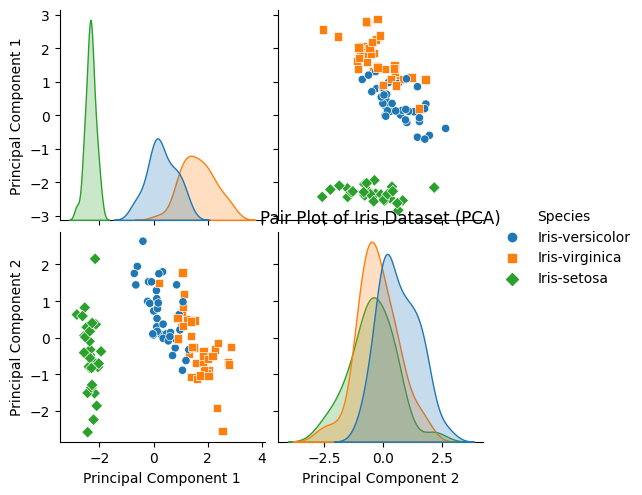

In [50]:
# Create a pair plot to visualize relationships between features after PCA
pca_df = pd.DataFrame(data=X_train_pca, columns=["Principal Component 1", "Principal Component 2"])
pca_df["Species"] = y_train
sns.pairplot(pca_df, hue="Species", markers=["o", "s", "D"])
plt.title("Pair Plot of Iris Dataset (PCA)")
plt.show()

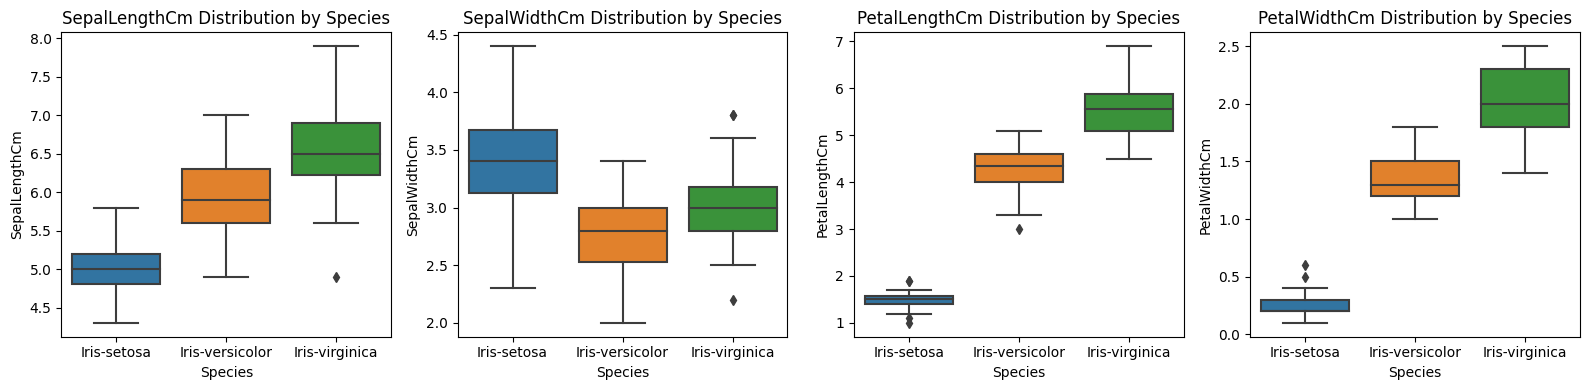

In [ ]:
# Visualize the distribution of each feature for each species side by side
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # Create 4 subplots in a single row

for i, feature in enumerate(iris_df.columns[1:5]):
    sns.boxplot(x="Species", y=feature, data=iris_df, ax=axes[i])
    axes[i].set_title(f"{feature} Distribution by Species")

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

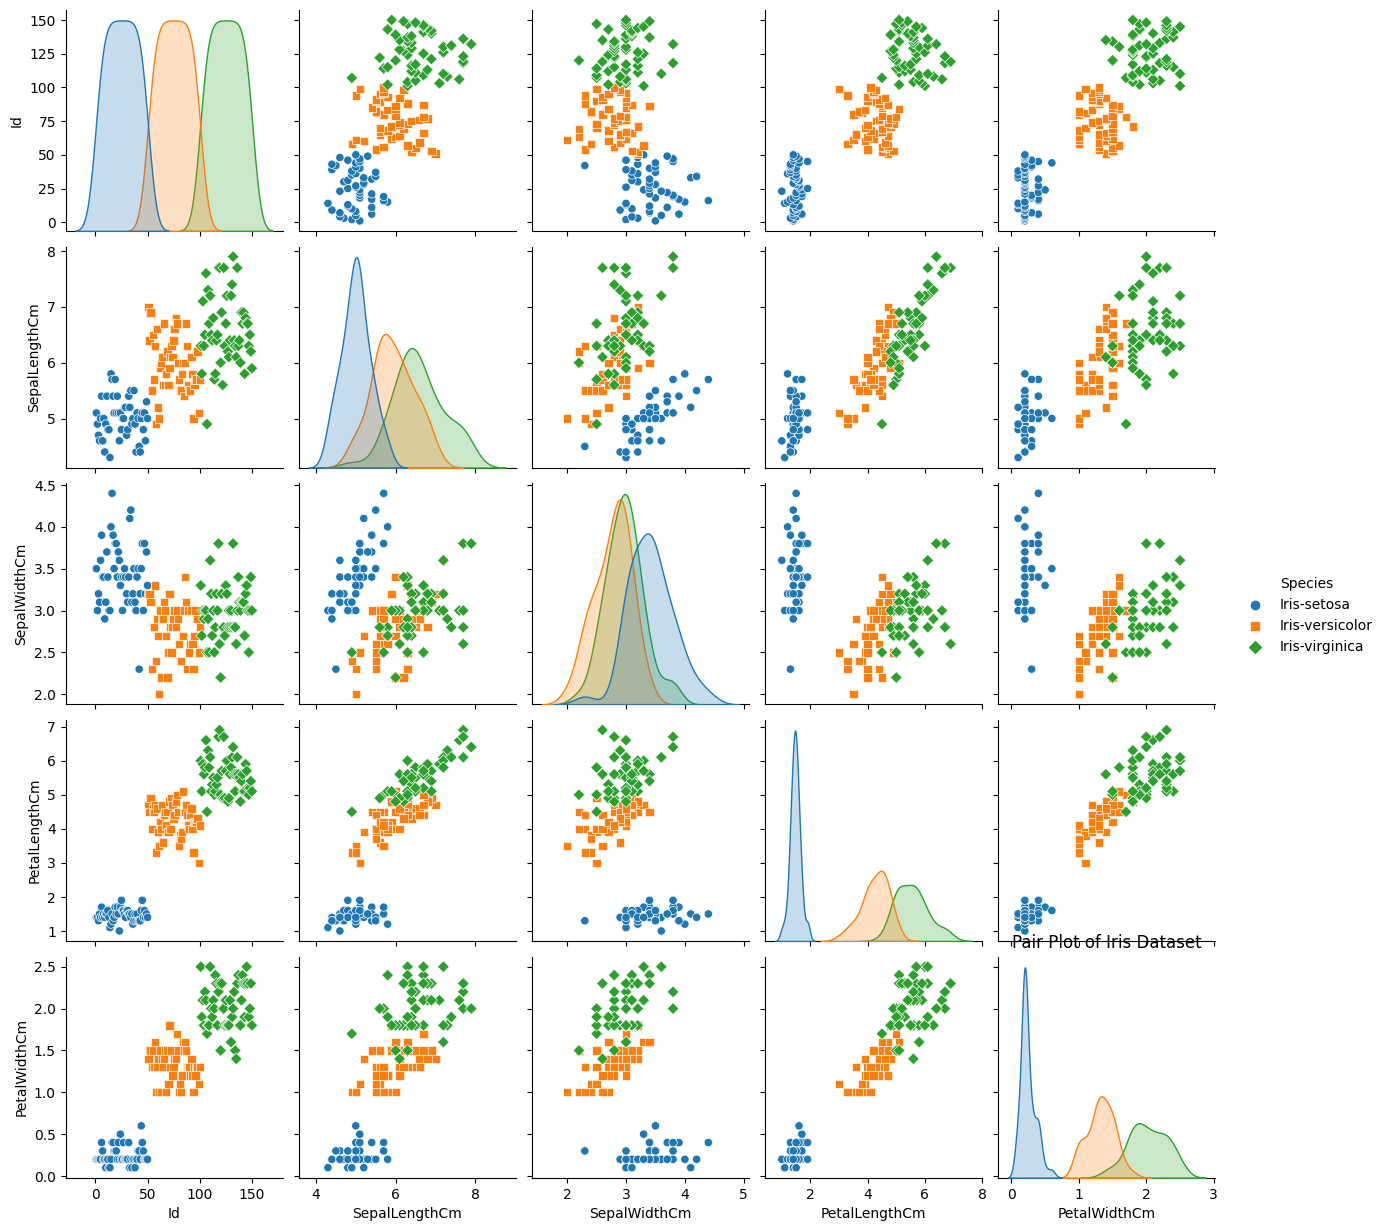

In [ ]:
# Create a pair plot to visualize relationships between features
sns.pairplot(iris_df, hue="Species", markers=["o", "s", "D"])
plt.title("Pair Plot of Iris Dataset")
plt.show()

In [63]:
# Encode the target values as integers for visualization
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [64]:
# Define a dictionary of models to compare
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC()
}

In [78]:
# Loop through each model, perform hyperparameter tuning, and evaluate with cross-validation
best_models = {}
validation_accuracies = []
test_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []

for model_name, model in models.items():
    if model_name == 'Random Forest':
        # Hyperparameter tuning for Random Forest
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 4, 5],
        }
        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(X_train_pca, y_train)  # Use PCA-transformed data
        best_model = grid_search.best_estimator_
    else:
        # Use the model with default hyperparameters for others
        best_model = model

    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train_pca, y_train, cv=5)  # Use PCA-transformed data
    mean_cv_accuracy = round(100 * np.mean(cv_scores), 2)
    validation_accuracies.append(mean_cv_accuracy)

    # Evaluate on the test set
    best_model.fit(X_train_pca, y_train)  # Use PCA-transformed data
    y_pred = best_model.predict(X_test_pca)
    test_accuracy = round(100 * accuracy_score(y_test, y_pred), 2)
    test_accuracies.append(test_accuracy)

    # Calculate precision, recall, and F1-score
    classification_rep = classification_report(y_test, y_pred, target_names=best_model.classes_, output_dict=True)
    precision_scores.append(classification_rep['weighted avg']['precision'])
    recall_scores.append(classification_rep['weighted avg']['recall'])
    f1_scores.append(classification_rep['weighted avg']['f1-score'])

    best_models[model_name] = {
        'model': best_model,
        'mean_cv_accuracy': mean_cv_accuracy,
        'test_accuracy': test_accuracy,
        'precision': classification_rep['weighted avg']['precision'],
        'recall': classification_rep['weighted avg']['recall'],
        'f1_score': classification_rep['weighted avg']['f1-score']
    }

# Find the best model based on cross-validation accuracy
best_model_name = max(best_models, key=lambda x: best_models[x]['mean_cv_accuracy'])

print(f"Best Model: {best_model_name}")
print(f"Cross-Validation Accuracy: {best_models[best_model_name]['mean_cv_accuracy']}%")
print(f"Test Accuracy: {best_models[best_model_name]['test_accuracy']}%")
print(f"Precision: {best_models[best_model_name]['precision']}")
print(f"Recall: {best_models[best_model_name]['recall']}")
print(f"F1-Score: {best_models[best_model_name]['f1_score']}")

Best Model: Random Forest
Cross-Validation Accuracy: 89.52%
Test Accuracy: 95.56%
Precision: 0.9614814814814815
Recall: 0.9555555555555556
F1-Score: 0.9552910052910052


In [82]:
# Create a list to store the results
results = []

for model_name, model_info in best_models.items():
    accuracy = model_info['test_accuracy']
    precision = model_info['precision']
    recall = model_info['recall']
    f1_score = model_info['f1_score']

    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    })

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

           Model  Accuracy  Precision    Recall  F1-Score
0  Random Forest     95.56   0.961481  0.955556  0.955291
1  Decision Tree     93.33   0.934656  0.933333  0.933235
2            SVM     93.33   0.934656  0.933333  0.933235


Decision Tree - Test Accuracy: 93.33%
SVM - Test Accuracy: 93.33%


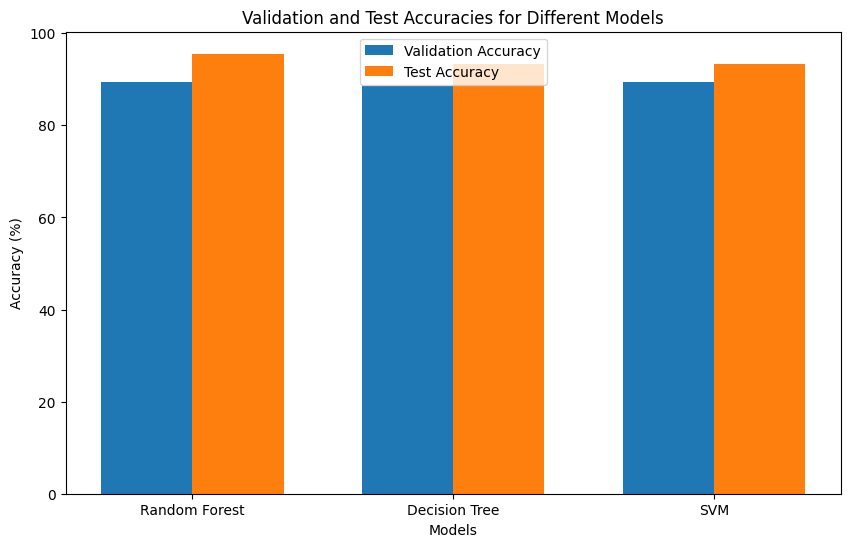

In [73]:
# Display test accuracy for all models
for model_name, results in best_models.items():
    if model_name != best_model_name:
        print(f"{model_name} - Test Accuracy: {results['test_accuracy']}%")

# Visualize validation and test accuracies
model_names = list(models.keys())
x = np.arange(len(model_names))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, validation_accuracies, width=bar_width, label='Validation Accuracy')
plt.bar(x + bar_width, test_accuracies, width=bar_width, label='Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Validation and Test Accuracies for Different Models')
plt.xticks(x + bar_width / 2, model_names)
plt.legend()
plt.show()

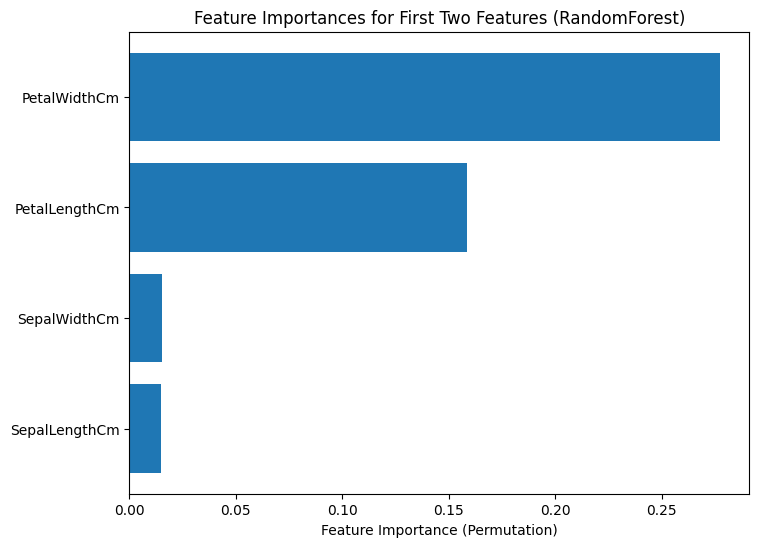

In [17]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier on your data (X_train, y_train)
rf_classifier.fit(X_train, y_train)

# Compute feature importances using permutation importance
perm_importance = permutation_importance(rf_classifier, X_train, y_train, n_repeats=30, random_state=0)

# Visualize feature importances
plt.figure(figsize=(8, 6))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(iris_df.columns[1:5], perm_importance.importances_mean[sorted_idx][:4])
plt.xlabel("Feature Importance (Permutation)")
plt.title("Feature Importances for First Two Features (RandomForest)")
plt.show()

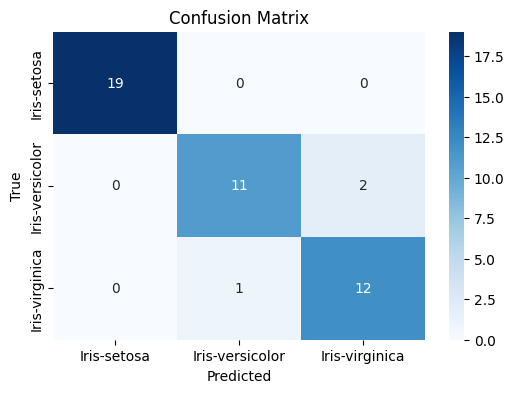

In [66]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=iris_df['Species'].unique(), yticklabels=iris_df['Species'].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

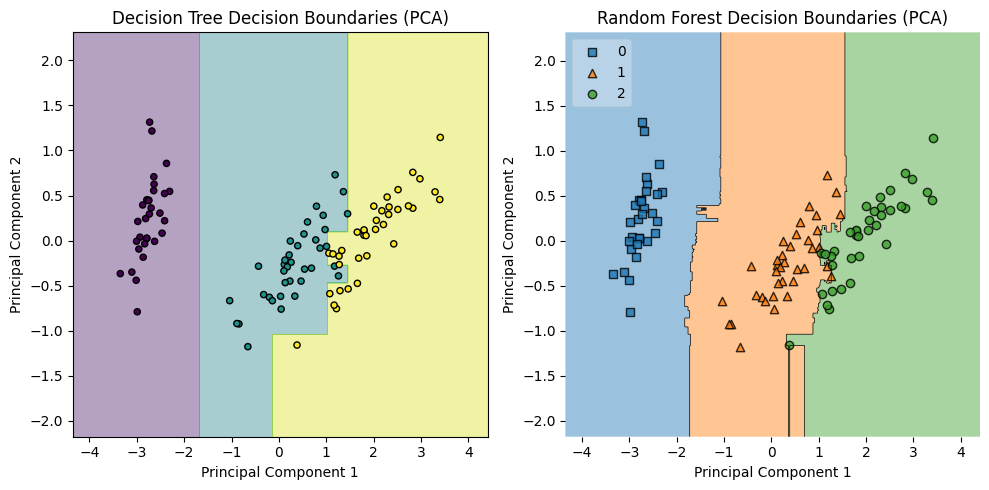

In [83]:
# Fit a PCA model to your data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Create a mesh grid for plotting the decision boundaries
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Create a Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Fit the Decision Tree classifier on your data (X_train_pca, y_train_encoded)
decision_tree_classifier.fit(X_train_pca, y_train_encoded)

# Make predictions on the mesh grid
Z_tree = decision_tree_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_tree = Z_tree.reshape(xx.shape)

# Plot the Decision Tree decision boundaries
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_tree, alpha=0.4, cmap='viridis')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap='viridis', s=20, edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Decision Tree Decision Boundaries (PCA)")

# Create a Random Forest classifier
random_forest_classifier = RandomForestClassifier(random_state=42)

# Fit the Random Forest classifier on your data (X_train_pca, y_train_encoded)
random_forest_classifier.fit(X_train_pca, y_train_encoded)

# Make predictions on the mesh grid
Z_forest = random_forest_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_forest = Z_forest.reshape(xx.shape)

# Plot the Random Forest decision boundaries
plt.subplot(1, 2, 2)
plot_decision_regions(X_train_pca, y_train_encoded, clf=random_forest_classifier, legend=2)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Random Forest Decision Boundaries (PCA)")

plt.tight_layout()
plt.show()